Train dataset size:(224, 20)
Test dataset size:(88, 20)

Train dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 224 entries, 0 to 223
Data columns (total 20 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   trainID        224 non-null    int64  
 1   N_Days         224 non-null    int64  
 2   Status         224 non-null    object 
 3   Drug           224 non-null    object 
 4   Age            224 non-null    int64  
 5   Sex            224 non-null    object 
 6   Ascites        224 non-null    object 
 7   Hepatomegaly   224 non-null    object 
 8   Spiders        224 non-null    object 
 9   Edema          224 non-null    object 
 10  Bilirubin      224 non-null    float64
 11  Cholesterol    201 non-null    float64
 12  Albumin        224 non-null    float64
 13  Copper         222 non-null    float64
 14  Alk_Phos       224 non-null    float64
 15  SGOT           224 non-null    float64
 16  Tryglicerides  200 no

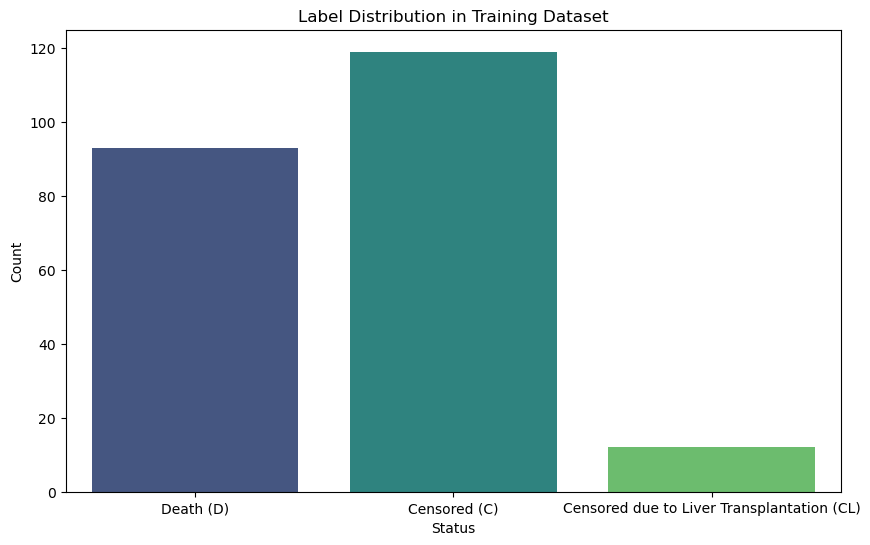

In [2]:
# Ans1 - Loading and exploring the datasets
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

# (a) Loading the datasets
train_data = pd.read_csv('Data/cirrhosis_train.csv')
test_data = pd.read_csv('Data/cirrhosis_test.csv')

# Displaying dataset sizes
train_size = train_data.shape
test_size = test_data.shape

print(f"Train dataset size:{train_size}")
print(f"Test dataset size:{test_size}")

#######################################################################################

# (b) Displaying feature types and checking for missing values
print("\nTrain dataset info:")
train_info = train_data.info()
missing_train = train_data.isnull().sum()
print("\nMissing values in Train dataset")
print(missing_train[missing_train > 0])
print("\nTest dataset info:")
test_info = test_data.info()
missing_test = test_data.isnull().sum()
print("\nMissing values in Test dataset\n")
print(missing_test[missing_test > 0])

#######################################################################################

# (c) Identifying columns with missing values
train_id = train_data['trainID']
train_data = train_data.drop('trainID', axis=1)
test_id = test_data['testID']
test_data = test_data.drop('testID', axis=1)

missing_train_columns = train_data.columns[train_data.isnull().any()]
missing_test_columns = test_data.columns[test_data.isnull().any()]

# Filling missing values in the training set
for column in missing_train_columns:
    train_data[column].fillna(train_data[column].mean(), inplace=True)

# Filling missing values in the test set
for column in missing_test_columns:
    test_data[column].fillna(test_data[column].mean(), inplace=True)


# Ensuring 'Status' column is treated as a categorical column
train_data['Status'] = train_data['Status'].astype('category')

#######################################################################################

# (d) Label encoding for 'Status' column
status_mapping = {'D': 0, 'C': 1, 'CL': 2}
train_data['Status'] = train_data['Status'].map(status_mapping)
test_data['Status'] = test_data['Status'].map(status_mapping)

# List of other categorical columns to encode (excluding 'Status')
categorical_columns = train_data.select_dtypes(include=['object', 'category']).columns.tolist()
categorical_columns.remove('Status')

# Applying one-hot encoding for other categorical features
train_data = pd.get_dummies(train_data, columns=categorical_columns)
test_data = pd.get_dummies(test_data, columns=categorical_columns)

# Aligning the train and test dataframes by the columns
train_data, test_data = train_data.align(test_data, join='left', axis=1, fill_value=0)

print("\nInfo: Label encoding applied to 'Status' and one-hot encoding applied to other categorical features.")

#######################################################################################

# (e) Label distribution based on the training data
# Counts in status
label_distribution = train_data['Status'].value_counts()
print("\nLabel distribution in the training dataset:")
print(label_distribution)

# Plotting the label distribution
warnings.filterwarnings("ignore", category=FutureWarning, module="seaborn.categorical")
plt.figure(figsize=(10, 6))
status_order = [0, 1, 2]
sns.countplot(x='Status', data=train_data, palette='viridis', order = status_order)
plt.title('Label Distribution in Training Dataset')
plt.xlabel('Status')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1, 2], labels=['Death (D)', 'Censored (C)', 'Censored due to Liver Transplantation (CL)'])
plt.show()


In [3]:
# Ans 2 - Supervised Machine Learning Models
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


# Splitting the data
X = train_data.drop('Status', axis=1)
y = train_data['Status']

# Standardizing the features
scaler = StandardScaler()
X = scaler.fit_transform(X)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Function to evaluate the models
def evaluate_model(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)
    accuracy = accuracy_score(y_val, y_pred)
    report = classification_report(y_val, y_pred, zero_division=0)
    return accuracy, report

# Model 1 - Logistic Regression
# Creating and evaluating Logistic Regression model
log_reg = LogisticRegression(max_iter=1000)
accuracy_lr, report_lr = evaluate_model(log_reg)
print("Logistic Regression - Accuracy:", accuracy_lr)
print("Logistic Regression - Classification Report:\n", report_lr)

# Model 2 - Random Forest with Hyperparameter Tuning
# Defining the parameter grid for Random Forest
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# Initializing GridSearchCV with more cross-validation folds
rf_model = RandomForestClassifier(random_state=42)
grid_search_rf = GridSearchCV(estimator=rf_model, param_grid=param_grid_rf, cv=5, n_jobs=-1, verbose=2)

# Fitting GridSearchCV
grid_search_rf.fit(X_train, y_train)

# Getting the best parameters from GridSearchCV
best_params_rf = grid_search_rf.best_params_
print("Best parameters for Random Forest:", best_params_rf)

# Evaluating Random Forest with the best parameters
rf_best_model = RandomForestClassifier(**best_params_rf, random_state=42)
accuracy_rf_best, report_rf_best = evaluate_model(rf_best_model)
print("Random Forest (Best) - Accuracy:", accuracy_rf_best)
print("Random Forest (Best) - Classification Report:\n", report_rf_best)

# Model 3 - Gradient Boosting
# Creating and evaluating Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
accuracy_gb, report_gb = evaluate_model(gb_model)
print("Gradient Boosting - Accuracy:", accuracy_gb)
print("Gradient Boosting - Classification Report:\n", report_gb)

# (b) Design Decisions for Each ML Model Used
# Logistic Regression: Simple and interpretable, useful as a baseline model.
# Random Forest: Can handle large datasets and capture non-linear relationships.
# Gradient Boosting: Builds an ensemble of weak learners to improve model performance, often yields high accuracy.

# (c) Logistic Regression: Hyperparameters Optimized: None.
# Random Forest: Hyperparameters Optimized: GridSearchCV
# Gradient Boosting: Hyperparameters Optimized: n_estimators (set to 100)

# (d) Oversampling, undersampling, class weights

# (e) from the result, the best model is Gradient Boosting


Logistic Regression - Accuracy: 0.8
Logistic Regression - Classification Report:
               precision    recall  f1-score   support

           0       0.81      0.72      0.76        18
           1       0.82      0.88      0.85        26
           2       0.00      0.00      0.00         1

    accuracy                           0.80        45
   macro avg       0.54      0.54      0.54        45
weighted avg       0.80      0.80      0.80        45

Fitting 5 folds for each of 81 candidates, totalling 405 fits
Best parameters for Random Forest: {'max_depth': None, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 200}
Random Forest (Best) - Accuracy: 0.8222222222222222
Random Forest (Best) - Classification Report:
               precision    recall  f1-score   support

           0       0.82      0.78      0.80        18
           1       0.82      0.88      0.85        26
           2       0.00      0.00      0.00         1

    accuracy                      

In [4]:
# Ans 3 - Best model
# Using the best model (Gradient Boosting) for prediction on the test set
best_model = GradientBoostingClassifier(n_estimators=100, random_state=42)
best_model.fit(X, y)

# Preprocessing the test set
X_test = test_data.drop(['Status'], axis=1)

# Standardising
X_test = scaler.transform(X_test)


# Making predictions on the test set
y_test_pred = best_model.predict(X_test)

status_mapping = {0: 'D', 1: 'C', 2: 'CL'}
y_test_pred_mapped = [status_mapping[pred] for pred in y_test_pred]


# Saving the predictions
predictions = pd.DataFrame({'testID': test_id, 'Status': y_test_pred_mapped})
predictions.to_csv('test_predictions.csv', index=False)

print("Predictions saved to 'test_predictions.csv'.")


Predictions saved to 'test_predictions.csv'.


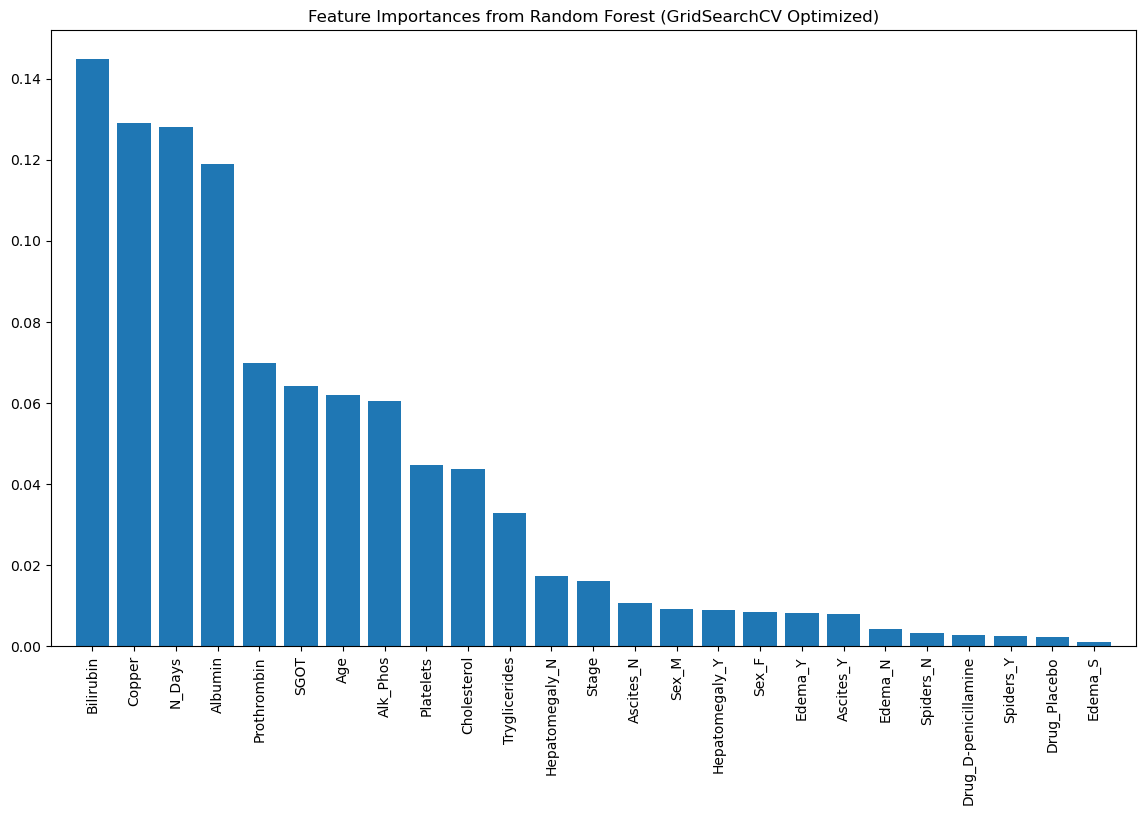

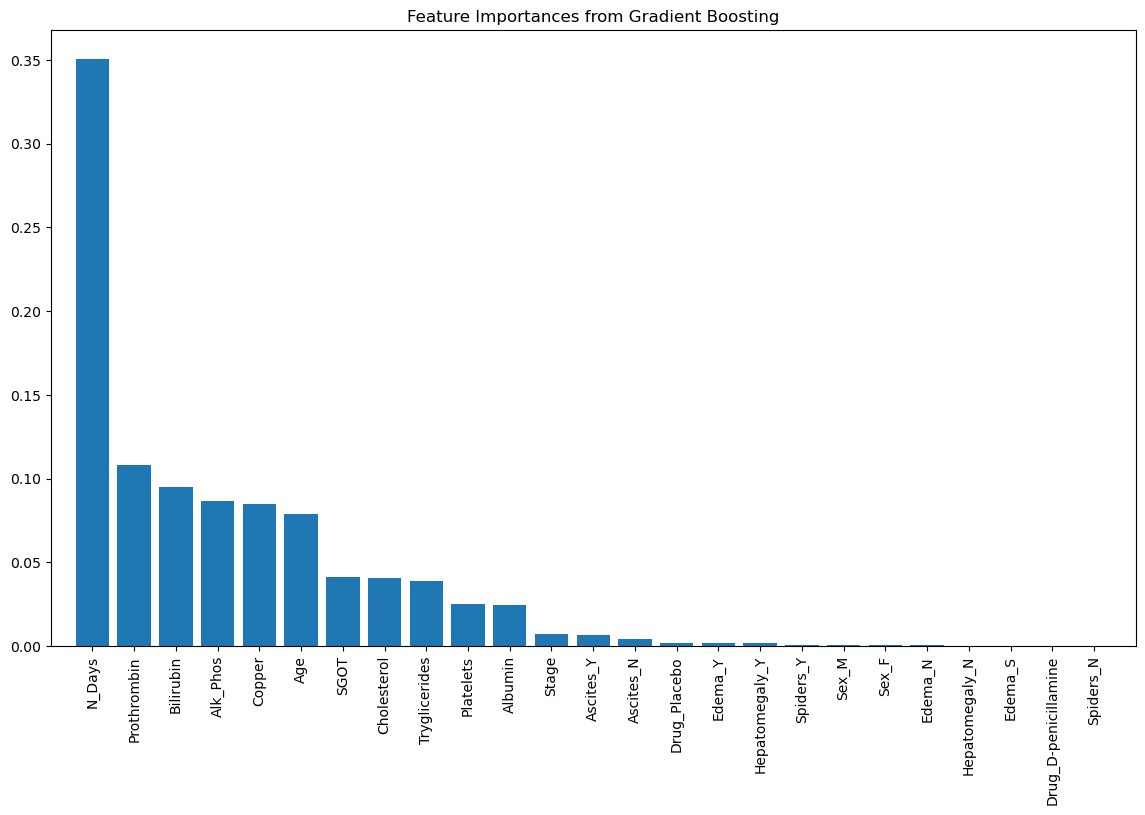

In [12]:
# Ans4 - Feature importance
# Feature Importance from Random Forest
feature_importances_rf = rf_best_model.feature_importances_
features = train_data.drop('Status', axis=1).columns
indices_rf = np.argsort(feature_importances_rf)[::-1]

plt.figure(figsize=(14, 8))
plt.title("Feature Importances from Random Forest (GridSearchCV Optimized)")
plt.bar(range(X_train.shape[1]), feature_importances_rf[indices_rf], align="center")
plt.xticks(range(X_train.shape[1]), features[indices_rf], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()


# Feature Importance from Gradient Boosting
feature_importances_gb = gb_model.feature_importances_
indices_gb = np.argsort(feature_importances_gb)[::-1]

plt.figure(figsize=(14, 8))
plt.title("Feature Importances from Gradient Boosting")
plt.bar(range(X_train.shape[1]), feature_importances_gb[indices_gb], align="center")
plt.xticks(range(X_train.shape[1]), features[indices_gb], rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()
